1. Data Exploration and Pre-processing:

- Load and explore the dataset to gain insights into the data's characteristics.
- Handle missing values, if any, and perform data cleansing as required.
- Perform data visualization to understand variables' distribution and relationships with them.


In [ ]:
import pandas as pd

# Load the dataset
url = "https://drive.google.com/uc?id=1O0C-Wf58FzeGRIQirGoFlZtucLGKSVHv"
df = pd.read_csv(url)

In [ ]:
# View the first 5 rows of the dataset

df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Display basic information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
# Perform describtive statistics of the dataset

df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
# Drop the redundant index column
df = df.drop(columns=["Unnamed: 0"])

# Check for duplicates in the 'tweet' column
duplicate_count = df.duplicated(subset="tweet").sum()

# Output duplicate count
print("Duplicate count:", duplicate_count)

Duplicate count: 0


In [ ]:
# check for duplicates

df[df.duplicated()]

,count,hate_speech,offensive_language,neither,class,tweet


In [ ]:
# Check for null or missing values

df.isnull().sum()

,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


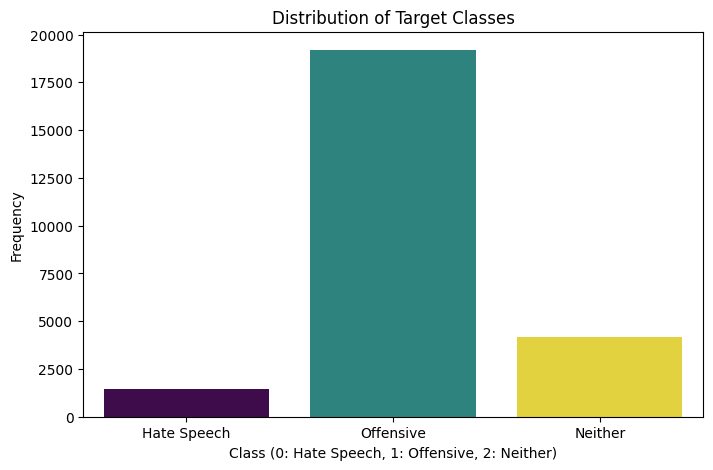

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['class'].value_counts()
# Visualize the distribution of the 'class' column
plt.figure(figsize=(8, 5))
sns.barplot(
    x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", legend=False
)
plt.title("Distribution of Target Classes")
plt.xlabel("Class (0: Hate Speech, 1: Offensive, 2: Neither)")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1, 2], labels=["Hate Speech", "Offensive", "Neither"])
plt.show()

In [ ]:
# Output class distribution
print("Class count:", class_counts)

Class count: class
1    19190
2     4163
0     1430
Name: count, dtype: int64


<Axes: >

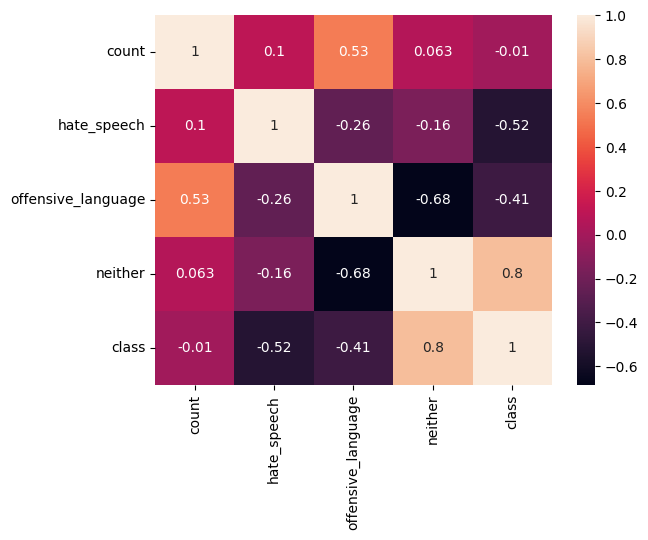

In [ ]:
# Visualize the correlation between the numerical columns

sns.heatmap(df[["count", "hate_speech", "offensive_language", "neither", "class"]].corr(), annot=True)


2. Feature Engineering Process:

-  Handle the outliers to prevent them from significantly affecting the model
- Extract meaningful information from the dataset using Feature Extraction Technique
- Reduce the number of features using PCA as the Dimensionality Reduction Technique
- Select the most prominent features to capture the complex relationships


In [ ]:
# Handle outliers in numeric features using the IQR method
def handle_outliers_replace(df):
    """
    Replaces outliers in the dataset with the 1st (Q1) or 3rd (Q3) quantile,
    depending on whether they are below or above the outlier thresholds.
    """
    Q1 = df.quantile(0.01)
    Q3 = df.quantile(0.99)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with respective quantiles
    df_cleaned = df.copy()
    for col in df.columns:
        df_cleaned[col] = df[col].where(df[col] >= lower_bound[col], Q1[col])
        df_cleaned[col] = df_cleaned[col].where(df_cleaned[col] <= upper_bound[col], Q3[col])
    return df_cleaned

# Apply the outlier handling function
numeric_features = df[["count", "hate_speech", "offensive_language", "neither"]]
numeric_features_cleaned = handle_outliers_replace(numeric_features)
numeric_features_cleaned.shape


(24783, 4)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction: Convert the 'tweet' column into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to 1000 features
tfidf_features = tfidf_vectorizer.fit_transform(df['tweet'])

# Combine TF-IDF features with numeric features
features_combined = pd.concat([
    pd.DataFrame(tfidf_features.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()),
    numeric_features_cleaned.reset_index(drop=True)
], axis=1)

print(f"Features shape: {features_combined.shape}")
features_combined.head()

Features shape: (24783, 1004)


,10,100,100046729,10084,1041204,11,12,12288,127814,128056,...,yesterday,yo,young,youre,youtube,yu,count,hate_speech,offensive_language,neither
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,3,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,3,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,2,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,0,6,0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Target column
target = df["class"]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_combined)

# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
features_pca = pca.fit_transform(features_scaled)

print(f"Reduced shape after PCA: {features_pca.shape}")

Reduced shape after PCA: (24783, 919)


3. Model Selection and Training:
- Split the dataset into training and testing sets.
- Select appropriate machine learning algorithms (e.g., logistic regression, decision trees, random forests, support vector machines, etc.) for the predictive modeling task.
- Train the selected models on the training data and evaluate their performance on the testing data.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.2, random_state=42)

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("----"*10)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("----"*10)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.92
----------------------------------------
Confusion Matrix:
[[ 180   94   16]
 [ 129 3642   61]
 [  27   85  723]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       290
           1       0.95      0.95      0.95      3832
           2       0.90      0.87      0.88       835

    accuracy                           0.92      4957
   macro avg       0.80      0.81      0.80      4957
weighted avg       0.92      0.92      0.92      4957



In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("----"*10)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("----"*10)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.94
----------------------------------------
Confusion Matrix:
[[ 116  155   19]
 [  19 3771   42]
 [   0   74  761]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.40      0.55       290
           1       0.94      0.98      0.96      3832
           2       0.93      0.91      0.92       835

    accuracy                           0.94      4957
   macro avg       0.91      0.77      0.81      4957
weighted avg       0.94      0.94      0.93      4957



In [ ]:
# Support Vector Machine

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

support_vector = SVC(kernel='linear', random_state=42)
support_vector.fit(X_train, y_train)

# Make predictions on the test set
y_pred = support_vector.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("----"*10)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("----"*10)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.96
----------------------------------------
Confusion Matrix:
[[ 239   48    3]
 [  48 3723   61]
 [  11   32  792]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       290
           1       0.98      0.97      0.98      3832
           2       0.93      0.95      0.94       835

    accuracy                           0.96      4957
   macro avg       0.90      0.91      0.91      4957
weighted avg       0.96      0.96      0.96      4957



In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("----"*10)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("----"*10)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.96
----------------------------------------
Confusion Matrix:
[[ 229   53    8]
 [  44 3760   28]
 [   7   44  784]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       290
           1       0.97      0.98      0.98      3832
           2       0.96      0.94      0.95       835

    accuracy                           0.96      4957
   macro avg       0.92      0.90      0.91      4957
weighted avg       0.96      0.96      0.96      4957



4. Hyperparameter Tuning:
- Fine-tune the hyperparameters of the chosen algorithm to optimize the model's performance and avoid model overfitting.

In [ ]:
# Decision Tree Grid Search

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

decision_tree_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=2,
                           verbose=3)

decision_tree_grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = decision_tree_grid_search.best_params_
best_score = decision_tree_grid_search.best_score_
decision_tree_optimised = decision_tree_grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", round(best_score, 2))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2;, score=0.937 total time=   9.2s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2;, score=0.945 total time=   8.5s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=5;, score=0.937 total time=   8.9s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=5;, score=0.945 total time=   9.2s
[CV 1/2] END criterion=gini, max_depth=10, min_samples_split=2;, score=0.927 total time=  17.7s
[CV 2/2] END criterion=gini, max_depth=10, min_samples_split=2;, score=0.931 total time=  16.6s
[CV 1/2] END criterion=gini, max_depth=10, min_samples_split=5;, score=0.928 total time=  16.9s
[CV 2/2] END criterion=gini, max_depth=10, min_samples_split=5;, score=0.934 total time=  17.1s
[CV 1/2] END criterion=entropy, max_depth=5, min_samples_split=2;, score=0.940 total time=  11.7s
[CV 2/2] END criterion=entropy, max_depth=5, min_samples_split=2;, score=0.945

In [ ]:
# Random Forest Grid Search

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

random_forest_instance = RandomForestClassifier(random_state=42)
random_forest_grid_search = GridSearchCV(
      estimator=random_forest_instance, param_grid=param_grid, cv=2, verbose=3)

random_forest_grid_search.fit(X_train, y_train)


# Get the best parameters and score
best_params = random_forest_grid_search.best_params_
best_score = random_forest_grid_search.best_score_
random_forest_optimised = random_forest_grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", round(best_score, 2))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.788 total time=  19.2s
[CV 2/2] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.782 total time=  18.8s
[CV 1/2] END max_depth=5, min_samples_split=2, n_estimators=200;, score=0.793 total time=  38.3s
[CV 2/2] END max_depth=5, min_samples_split=2, n_estimators=200;, score=0.791 total time=  38.5s
[CV 1/2] END max_depth=5, min_samples_split=5, n_estimators=100;, score=0.788 total time=  18.7s
[CV 2/2] END max_depth=5, min_samples_split=5, n_estimators=100;, score=0.785 total time=  20.8s
[CV 1/2] END max_depth=5, min_samples_split=5, n_estimators=200;, score=0.791 total time=  38.5s
[CV 2/2] END max_depth=5, min_samples_split=5, n_estimators=200;, score=0.791 total time=  37.9s
[CV 1/2] END max_depth=10, min_samples_split=2, n_estimators=100;, score=0.913 total time=  35.5s
[CV 2/2] END max_depth=10, min_samples_split=2, n_estimators=100;,

In [ ]:
# Support vector grid search

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C': [1, 10]}

svc_instance = SVC(random_state=42)
svc_grid_search = GridSearchCV(svc_instance, parameters, scoring='accuracy', verbose=3, cv=2)

# fitting the model for grid search
svc_grid_search.fit(X_train , y_train)

# summarize
print('Best Score: %.2f' % svc_grid_search.best_score_)
print('Best Parameters: %s' % svc_grid_search.best_params_)

# Assign best estimator
support_vector_optimised = svc_grid_search.best_estimator_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ................C=1, kernel=linear;, score=0.951 total time=  15.4s
[CV 2/2] END ................C=1, kernel=linear;, score=0.950 total time=  16.9s
[CV 1/2] END ...................C=1, kernel=rbf;, score=0.921 total time= 1.6min
[CV 2/2] END ...................C=1, kernel=rbf;, score=0.925 total time= 1.8min
[CV 1/2] END ...............C=10, kernel=linear;, score=0.951 total time=  15.2s
[CV 2/2] END ...............C=10, kernel=linear;, score=0.942 total time=  18.8s
[CV 1/2] END ..................C=10, kernel=rbf;, score=0.947 total time= 1.4min
[CV 2/2] END ..................C=10, kernel=rbf;, score=0.946 total time= 1.4min
Best Score: 0.95
Best Parameters: {'C': 1, 'kernel': 'linear'}


In [ ]:
# Logistic regression tuning

logistic_regression_instance = LogisticRegression(max_iter=100, random_state=42)
model_parameter_grid = {
    'C': [0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'liblinear']
}
logistic_regression_grid_search = GridSearchCV(
      logistic_regression_instance,
      param_grid=model_parameter_grid,
      verbose=3,
      cv=2,
      scoring='accuracy'
      )

# fitting the model for grid search
logistic_regression_grid_search.fit(X_train , y_train)

# summarize
print('Best Score: %.2f' % logistic_regression_grid_search.best_score_)
print('Best Parameters: %s' % logistic_regression_grid_search.best_params_)

# Assign best estimator
logistic_regression_optimised = logistic_regression_grid_search.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.961 total time=   1.8s
[CV 2/2] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.963 total time=   1.6s
[CV 1/2] END C=0.1, penalty=l2, solver=newton-cg;, score=0.961 total time=   3.4s
[CV 2/2] END C=0.1, penalty=l2, solver=newton-cg;, score=0.963 total time=   5.2s
[CV 1/2] END C=0.1, penalty=l2, solver=liblinear;, score=0.966 total time=  10.2s
[CV 2/2] END C=0.1, penalty=l2, solver=liblinear;, score=0.964 total time=  10.6s
[CV 1/2] END .....C=1, penalty=l2, solver=lbfgs;, score=0.959 total time=   1.6s
[CV 2/2] END .....C=1, penalty=l2, solver=lbfgs;, score=0.958 total time=   2.0s
[CV 1/2] END .C=1, penalty=l2, solver=newton-cg;, score=0.959 total time=   5.3s
[CV 2/2] END .C=1, penalty=l2, solver=newton-cg;, score=0.960 total time=   5.5s
[CV 1/2] END .C=1, penalty=l2, solver=liblinear;, score=0.963 total time=  21.0s
[CV 2/2] END .C=1, penalty=l2, solver=libline

5. Model Evaluation:
- Compare the performance of different models using appropriate evaluation metrics such as accuracy, precision, recall, F1-score, area under the receiver operating characteristic curve (AUC-ROC), Confusion matrix, and Logarithmic loss (Log Loss).
- Comparative analysis to identify the best-performing model for classification.

Evaluating Logistic Regression...
Confusion Matrix for Logistic Regression:


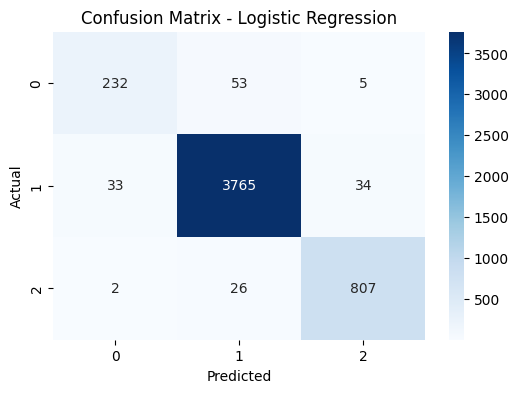

Evaluating Decision Tree...
Confusion Matrix for Decision Tree:


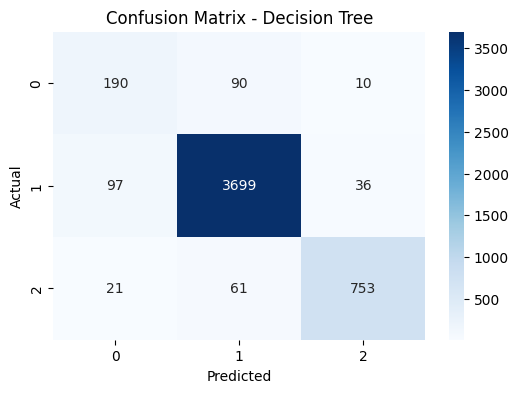

Evaluating Random Forest...
Confusion Matrix for Random Forest:


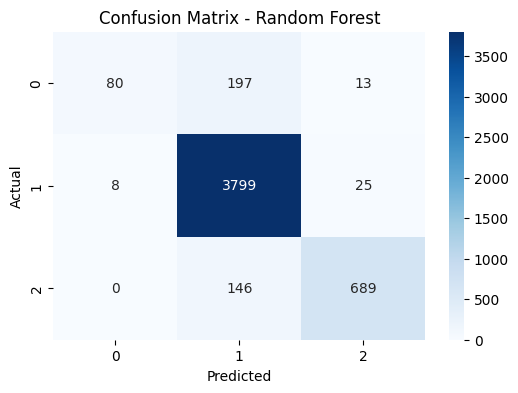

Evaluating Support Vector Machine...
Confusion Matrix for Support Vector Machine:


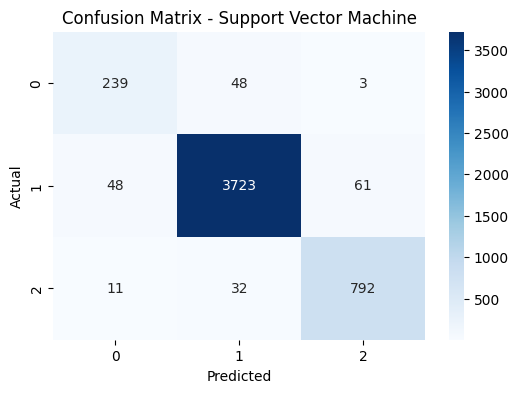


Comparative Analysis of Model Performance:
                        Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
Logistic Regression     0.969135   0.968678  0.969135  0.968814  0.988976   
Support Vector Machine  0.959048   0.959561  0.959048  0.959260       NaN   
Decision Tree           0.936454   0.937569  0.936454  0.936898  0.974357   
Random Forest           0.921525   0.921860  0.921525  0.909966  0.977665   

                        Log Loss  
Logistic Regression     0.106213  
Support Vector Machine       NaN  
Decision Tree           0.213645  
Random Forest           0.292950  

Best-performing model: Logistic Regression


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix
)


# Define models for comparison
models = {
    "Logistic Regression": logistic_regression_optimised,
    "Decision Tree": decision_tree_optimised,
    "Random Forest": random_forest_optimised,
    "Support Vector Machine": support_vector_optimised,
}

# Dictionary to store performance metrics
performance_metrics = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")


    # Predict probabilities for AUC-ROC and log loss
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr") if y_pred_proba is not None else None
    logloss = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else None
    confusion = confusion_matrix(y_test, y_pred)

    # Store metrics
    performance_metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc_roc,
        "Log Loss": logloss
    }

    # Print confusion matrix
    print(f"Confusion Matrix for {model_name}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Comparative analysis of model performance
performance_df = pd.DataFrame(performance_metrics).T
performance_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\nComparative Analysis of Model Performance:")
print(performance_df)

# Highlight the best-performing model
best_model_name = performance_df.index[0]
print(f"\nBest-performing model: {best_model_name}")


6. Model Deployment:
- Deploy the model to generate predictions for new and previously unseen data.


In [ ]:
import pickle

# Save the best-performing model for deployment
best_model = models[best_model_name]
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

# Function to preprocess new data
def preprocess_new_data(new_data, tfidf_vectorizer, pca, scaler):
    """
    Preprocesses new data for predictions:
    - TF-IDF extraction from 'tweet'
    - Standardization and PCA transformation
    """
    # Extract TF-IDF features
    tfidf_features_new = tfidf_vectorizer.transform(new_data["tweet"])

    # Combine TF-IDF features with numeric features
    numeric_features_new = new_data[["count", "hate_speech", "offensive_language", "neither"]]
    combined_features_new = pd.concat([
        pd.DataFrame(tfidf_features_new.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
        numeric_features_new.reset_index(drop=True)
    ], axis=1)

    # Standardize and apply PCA transformation
    combined_features_scaled = scaler.transform(combined_features_new)
    combined_features_pca = pca.transform(combined_features_scaled)

    return combined_features_pca

# Load the saved model for deployment
with open("best_model.pkl", "rb") as model_file:
    deployed_model = pickle.load(model_file)

# Example: Load new data
new_data = pd.DataFrame({
    "tweet": ["This is a test tweet about something offensive.", "This is neutral content."],
    "count": [10, 5],
    "hate_speech": [0, 0],
    "offensive_language": [5, 1],
    "neither": [5, 4]
})

# Preprocess the new data
new_data_preprocessed = preprocess_new_data(new_data, tfidf_vectorizer, pca, scaler)

In [ ]:
predictions = deployed_model.predict(new_data_preprocessed)
predictions

array([1, 2])